# Predicting Movie Success

In [76]:
import pandas as pd
import numpy as np
import re # imports regular expressions
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Cleaning and Extracting the Data

In [77]:
# CLEANING THE IMDB DATAFRAME
pd.set_option('display.max_colwidth', -1) # Will not truncate the dataframe columns
imdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True, encoding="utf8")

# If omdb_awards = N/A (ie no awards), set it to 0
imdb.loc[imdb['omdb_awards'] == 'N/A', 'omdb_awards'] = 0

# Since omdb_awards is not very consistent in how it displays the data, and not all of the data tells the name of the award,
# we will instead sum the number of awards and nominations, as I believe that the data is still important, although being
# inconsistlenty presented

# Gets total number of awards and nominations
def get_awards(string):
        string = str(string) # convert input to string if not already so that we can use regex
        numbers = re.findall(r'[0-9]+', string) # find all the digits in the string
        numbers = list(map(int, numbers)) # convert the list of strings to ints
        return sum(numbers)
imdb['omdb_awards_sum'] = imdb['omdb_awards'].apply(get_awards)

# Re-ordering columns
imdb = imdb[['omdb_awards', 'omdb_awards_sum', 'omdb_plot', 'omdb_genres', 'imdb_id']] 

# TODO: Natural language processing here if needed

# Show the table
#imdb

In [78]:
# CLEANING THE WIKIDATA DATAFRAME
wikidata = pd.read_json('wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8")

# The number of cast members and filming locations may be important as it gives an idea of the production value of a film,
# so we calcualte those values
def get_totals(string):
        string = str(string) # convert input to string if not already so that we can use regex
        numbers = re.findall(r'[0-9]+', string) # find all the digits (ids) in the string
        return len(numbers) # return the number of ids found
wikidata['cast_members_total'] = wikidata['cast_member'].apply(get_totals)
wikidata['filming_location_total'] = wikidata['filming_location'].apply(get_totals)

# Re-ordering columns
wikidata = wikidata[['label', 'enwiki_title', 'director', 'cast_member', 'cast_members_total', 'filming_location', 
                     'filming_location_total', 'genre', 'main_subject', 'publication_date', 'made_profit', 'based_on', 
                     'country_of_origin','original_language', 'wikidata_id', 'imdb_id','metacritic_id', 'rotten_tomatoes_id']] 
# Show the table
#wikidata

# Note: Previously I dropped columns here that I did not find useful and the dropped nulls, however doing so resulted in very
# little data being left (only 24 rows). So we will drop nulls and columns when need be according to the question.

In [79]:
# The rotten tomatoes dataframe does not require and cleaning
rotten_tomatoes = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True, encoding="utf8")
#rotten_tomatoes

# Is there a difference in ratings between genres?

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
   action    adventure   0.4751   0.1308  0.8193  True 
   action    animation   0.7405   0.3962  1.0847  True 
   action    biography   1.1505   0.8062  1.4947  True 
   action      comedy    0.2926  -0.0517  0.6368 False 
   action      crime     0.9783   0.6341  1.3226  True 
   action   documentary  1.4757   1.1315   1.82   True 
   action      drama     0.8735   0.5292  1.2177  True 
   action      horror   -0.2495  -0.5938  0.0947 False 
 adventure   animation   0.2654  -0.0789  0.6096 False 
 adventure   biography   0.6754   0.3312  1.0196  True 
 adventure     comedy   -0.1825  -0.5268  0.1617 False 
 adventure     crime     0.5032   0.159   0.8475  True 
 adventure  documentary  1.0006   0.6564  1.3449  True 
 adventure     drama     0.3984   0.0541  0.7426  True 
 adventure     horror   -0.7246  -1.0688 -0.3804

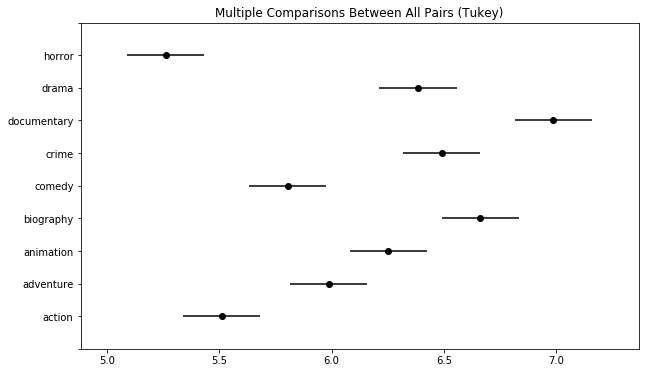

In [80]:
# DOES GENRE AFFECT MOVIE RATINGS? (we will look at critic ratings)
# Get the genre data
genres = wikidata.copy()
genres = genres.drop(columns = ['director', 'cast_member', 'cast_members_total', 'filming_location', 
                                'filming_location_total', 'label', 'main_subject', 'publication_date', 'made_profit', 
                                'based_on', 'country_of_origin', 'original_language', 'metacritic_id', 'rotten_tomatoes_id',
                                'wikidata_id'])

# Get the ratings data and join with the genres table
ratings = rotten_tomatoes.copy()
ratings = ratings.drop(columns = ['audience_average', 'audience_percent', 'audience_ratings', 'rotten_tomatoes_id', 
                                  'critic_percent'])
data = pd.merge(genres, ratings, on='imdb_id', how='inner')

# Get the genres from imdb and comparing to the genres from wikidata
imdb_genres = imdb.copy
imdb_genres = imdb.drop(columns = ['omdb_awards', 'omdb_awards_sum', 'omdb_plot'])
data = pd.merge(data, imdb_genres, on='imdb_id', how='inner')
data = data.drop(columns = ['genre', 'imdb_id']) # drop the wikidata genres as they are too specific
data

# Movies can have multiple genres. However, we will instead choose the first genre that appears in the list as it will
# describe the overall movie better (note: the omdb_genres are not listed alphabetically)
def get_genre(list):
        return list[0]
data['genre'] = data['omdb_genres'].apply(get_genre)
data = data.drop(columns = ['enwiki_title', 'omdb_genres'])
data = data.dropna()

# Count how many ratings each genre has, we will only keep the ones that have 40 or more ratings
genre_list = data.groupby(['genre']).count()
genre_list = genre_list[genre_list.critic_average > 39] # the following 9 genres have >39 points
action = data[data.genre == 'Action']
adventure = data[data.genre == 'Adventure']
animation = data[data.genre == 'Animation'] 
biography = data[data.genre == 'Biography'] 
comedy = data[data.genre == 'Comedy']
crime = data[data.genre == 'Crime']
documentary = data[data.genre == 'Documentary']
drama = data[data.genre == 'Drama'] 
horror = data[data.genre == 'Horror'] 

# Getting just the ratings values (note: had to fix index else the melt didnt work)
action = action.head(309).reset_index().drop(columns='index').critic_average
adventure = adventure.head(309).reset_index().drop(columns='index').critic_average
animation = animation.head(309).reset_index().drop(columns='index').critic_average
biography = biography.head(309).reset_index().drop(columns='index').critic_average
comedy = comedy.tail(309).reset_index().drop(columns='index').critic_average
crime = crime.head(309).reset_index().drop(columns='index').critic_average
documentary = documentary.head(309).reset_index().drop(columns='index').critic_average
drama = drama.head(309).reset_index().drop(columns='index').critic_average
horror = horror.head(309).reset_index().drop(columns='index').critic_average

# We will do an ANOVA test to see if there is a differnce of means between genres
# alpha = 0.05
# First we must satisfy the conditions of ANOVA
    # 1. Observations independent and identically distributed (iid) [satisfied]
    # 2. Groups are normally distributed. [satisfied]
    # 3. Groups have equal variance. [satisfied]

# Checking normality
_, action_p = stats.normaltest(action)            # passes, p = 0.00046241715224028767
_, adventure_p = stats.normaltest(adventure)      # passes, p = 0.011924851969263702
_, animation_p = stats.normaltest(animation)      # passes, p = 0.0.003976243675659536
_, biography_p = stats.normaltest(biography)      # passes, p = 0.0.0014181441862871145
_, crime_p = stats.normaltest(crime)              # passes, p = 0.008638373241118949
_, comedy_p = stats.normaltest(comedy)            # passes, p = 0.024046548953102265
_, documentary_p = stats.normaltest(documentary)  # passes, p = 7.998554989438047e-32
_, drama_p = stats.normaltest(drama)              # passes, p = 0.030866535542731395
_, horror_p = stats.normaltest(horror)            # passes, p = 0.03131767590918678

# Checking for equal vairances: passes, p = 1.9136925363053607e-21
levene_test = stats.levene(action, adventure, animation, biography, comedy, crime, documentary, drama, horror).pvalue

# Doing the ANOVA test # passes, p = 9.826002586735975e-77, there is a difference in means between the genres
anova = stats.f_oneway(action, adventure, animation, biography, comedy, crime, documentary, drama, horror)
anova_pvalue = anova.pvalue 

# Post Hoc Analysis (Tukeys HSD test)
x_data = pd.DataFrame({'action':action, 'adventure':adventure, 'animation':animation, 'biography': biography, 'comedy': comedy, 
                      'crime': crime, 'documentary': documentary, 'drama': drama, 'horror': horror})
x_melt = pd.melt(x_data)
posthoc = pairwise_tukeyhsd(x_melt['value'], x_melt['variable'], alpha=0.05)

# Display the Tukey results
fig = posthoc.plot_simultaneous()
print(posthoc)

# Have the average critic ratings of genres changed over the years?

In [81]:
# Have the average ratings for different genres changed over the years. For example, has there been a decline in the quality of 
# horror movies. We will looking at critic_average by the year

In [82]:
# DOES GENRE AFFECT MOVIE RATINGS? (we will look at critic ratings)
# Get the genre data
genres = wikidata.copy()
genres = genres.drop(columns = ['director', 'cast_member', 'cast_members_total', 'filming_location', 
                                'filming_location_total', 'label', 'main_subject', 'made_profit', 
                                'based_on', 'country_of_origin', 'original_language', 'metacritic_id', 'rotten_tomatoes_id',
                                'wikidata_id'])

# Get the ratings data and join with the genres table
ratings = rotten_tomatoes.copy()
ratings = ratings.drop(columns = ['audience_average', 'audience_percent', 'audience_ratings', 'rotten_tomatoes_id', 
                                  'critic_percent'])
data = pd.merge(genres, ratings, on='imdb_id', how='inner')

# Get the genres from imdb and comparing to the genres from wikidata
imdb_genres = imdb.copy
imdb_genres = imdb.drop(columns = ['omdb_awards', 'omdb_awards_sum', 'omdb_plot'])
data = pd.merge(data, imdb_genres, on='imdb_id', how='inner')
data = data.drop(columns = ['genre', 'imdb_id']) # drop the wikidata genres as they are too specific
data

# Movies can have multiple genres. However, we will instead choose the first genre that appears in the list as it will
# describe the overall movie better (note: the omdb_genres are not listed alphabetically)
def get_genre(list):
        return list[0]
data['genre'] = data['omdb_genres'].apply(get_genre)
data = data.drop(columns = ['enwiki_title', 'omdb_genres'])
data = data.dropna()

# Count how many ratings each genre has, we will only keep the ones that have 40 or more ratings
genre_list = data.groupby(['genre']).count()
genre_list = genre_list[genre_list.critic_average > 39] # the following 9 genres have >39 points
action = data[data.genre == 'Action']
adventure = data[data.genre == 'Adventure']
animation = data[data.genre == 'Animation'] 
biography = data[data.genre == 'Biography'] 
comedy = data[data.genre == 'Comedy']
crime = data[data.genre == 'Crime']
documentary = data[data.genre == 'Documentary']
drama = data[data.genre == 'Drama'] 
horror = data[data.genre == 'Horror'] 

# Getting just the ratings values (note: had to fix index else the melt didnt work)
action = action.head(309).reset_index().drop(columns='index')
adventure = adventure.head(309).reset_index().drop(columns='index')
animation = animation.head(309).reset_index().drop(columns='index')
biography = biography.head(309).reset_index().drop(columns='index')
comedy = comedy.tail(309).reset_index().drop(columns='index')
crime = crime.head(309).reset_index().drop(columns='index')
documentary = documentary.head(309).reset_index().drop(columns='index')
drama = drama.head(309).reset_index().drop(columns='index')
horror = horror.head(309).reset_index().drop(columns='index')

# Get the year from the date string
def get_year(date):
        string = str(date) 
        year = re.findall(r'[0-9]+', date) 
        return year[0] 

# Getting the year from the date
action['year'] = action['publication_date'].apply(get_year).astype(int)
adventure['year'] = adventure['publication_date'].apply(get_year).astype(int)
animation['year'] = animation['publication_date'].apply(get_year).astype(int)
biography['year'] = biography['publication_date'].apply(get_year).astype(int)
comedy['year'] = comedy['publication_date'].apply(get_year).astype(int)
crime['year'] = crime['publication_date'].apply(get_year).astype(int)
documentary['year'] = documentary['publication_date'].apply(get_year).astype(int)
drama['year'] = drama['publication_date'].apply(get_year).astype(int)
horror['year'] = horror['publication_date'].apply(get_year).astype(int)

# Get the average critic_score for each year and sort by year in ascending order (reset index else year becomes the index)
action = action.groupby(['year']).mean().sort_values(by=['year']).reset_index()
adventure = adventure.groupby(['year']).mean().sort_values(by=['year']).reset_index()
animation = animation.groupby(['year']).mean().sort_values(by=['year']).reset_index()
biography = biography.groupby(['year']).mean().sort_values(by=['year']).reset_index()
comedy = comedy.groupby(['year']).mean().sort_values(by=['year']).reset_index()
crime = crime.groupby(['year']).mean().sort_values(by=['year']).reset_index()
documentary = documentary.groupby(['year']).mean().sort_values(by=['year']).reset_index()
drama = drama.groupby(['year']).mean().sort_values(by=['year']).reset_index()
horror = horror.groupby(['year']).mean().sort_values(by=['year']).reset_index()

# Getting the data within range
action = action[(action.year > 1959) & (action.year < 2011)]
adventure = adventure[(adventure.year > 1959) & (adventure.year < 2011)]
animation = animation[(animation.year > 1959) & (animation.year < 2011)]
biography = biography[(biography.year > 1959) & (biography.year < 2011)]
comedy = comedy[(comedy.year > 1959) & (comedy.year < 2011)]
crime = crime[(crime.year > 1959) & (crime.year < 2011)]
documentary = documentary[(documentary.year > 1959) & (documentary.year < 2011)]
drama = drama[(drama.year > 1959) & (drama.year < 2011)]
horror = horror[(horror.year > 1959) & (horror.year < 2011)]

In [83]:
# In order to be able to do a linear regression on all the genres, we will need to have a consistent number of points between
# all genres. We have chosen the range for the years as being 1960 - 2010, as most genres have data for these points. We will
# then interpolate the missing values. We will not include the 'documentary' genre in our analysis as we only have 25 out out
# the possible 50 points, thus interpolating half the data will be of no use
data = np.arange(1960,2011)
years = pd.DataFrame(data, columns = ['year']) 
action = pd.merge(action, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(action.mean())
adventure = pd.merge(adventure, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(adventure.mean())
animation = pd.merge(animation, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(animation.mean())
biography = pd.merge(biography, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(biography.mean())
comedy = pd.merge(comedy, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(comedy.mean())
crime = pd.merge(crime, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(crime.mean())
drama = pd.merge(drama, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(drama.mean())
horror = pd.merge(horror, years, on='year', how='outer').sort_values(by=['year']).reset_index().drop(columns='index').interpolate().fillna(horror.mean())

0.008269964369337092
0.003547588480829395
0.0005802222454377435
1.8727704215116653e-06
1.9606480298556743e-06
0.3146524919626632
3.882708646501703e-05


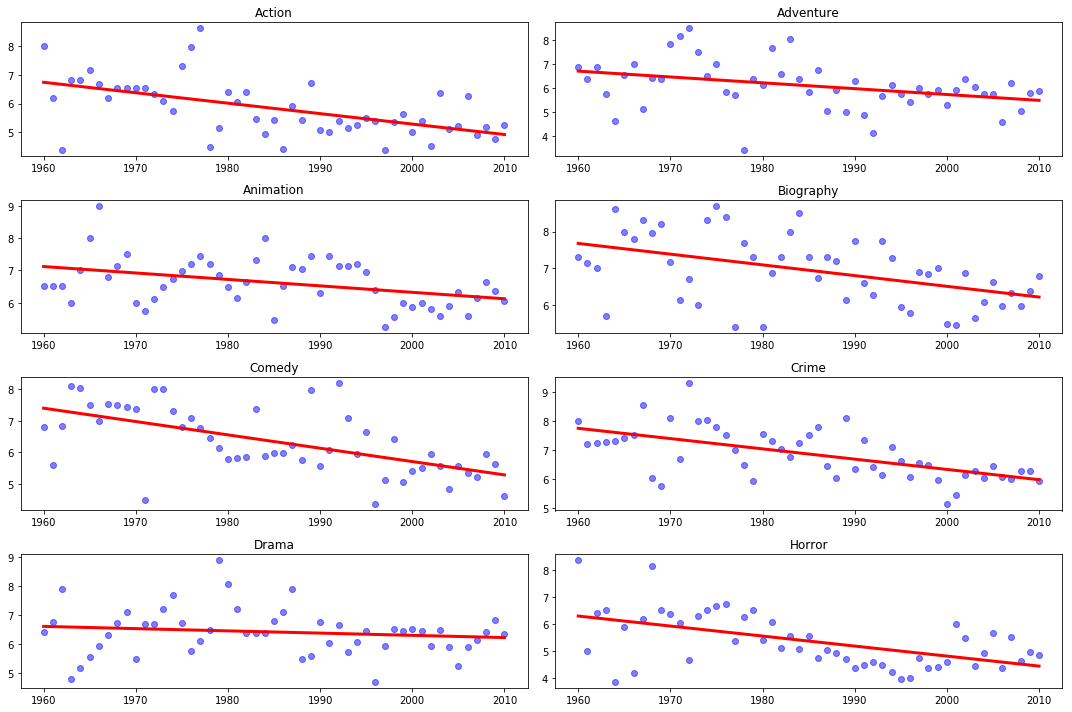

In [84]:
# Plotting the data
plt.figure(figsize=(15, 10))

plt.subplot(4, 2, 1)
data = action
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Action')

plt.subplot(4, 2, 2)
data = adventure
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Adventure')
print(fit.pvalue)

plt.subplot(4, 2, 3)
data = animation
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Animation')
print(fit.pvalue)

plt.subplot(4, 2, 4)
data = biography
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Biography')
print(fit.pvalue)

plt.subplot(4, 2, 5)
data = comedy
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Comedy')
print(fit.pvalue)

plt.subplot(4, 2, 6)
data = crime
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Crime')
print(fit.pvalue)

plt.subplot(4, 2, 7)
data = drama
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Drama')
print(fit.pvalue)

plt.subplot(4, 2, 8)
data = horror
fit = stats.linregress(data['year'], data['critic_average'])
data['prediction'] = data['year']*fit.slope + fit.intercept
plt.plot(data['year'], data['critic_average'], 'bo', alpha=0.5)
plt.plot(data['year'], data['prediction'], 'r-', linewidth=3)
plt.title('Horror')
print(fit.pvalue)

plt.tight_layout()

# Can we predict genre based on ratings and year?

In [85]:
# Get the genres
genres = imdb.copy()
genres = genres.drop(columns=['omdb_awards', 'omdb_awards_sum', 'omdb_plot'])

# Get the dates
dates = wikidata.copy()
dates = dates.drop(columns = ['director', 'cast_member', 'filming_location', 'label', 'main_subject', 'made_profit', 
                                'based_on', 'country_of_origin', 'original_language', 'metacritic_id', 'rotten_tomatoes_id',
                                'wikidata_id', 'enwiki_title', 'genre'])

# Get the ratings
ratings = rotten_tomatoes.copy()
ratings = ratings.drop(columns = ['rotten_tomatoes_id'])

# Joining the datframes
data = pd.merge(genres, dates, on='imdb_id', how='inner')
data = pd.merge(data, ratings, on='imdb_id', how='inner')
data = data.dropna()

# Cleaning the data: Get the year from the date string
def get_year(date): 
        string = str(date) 
        year = re.findall(r'[0-9]+', date) 
        return year[0] 
data['publication_date'] = data['publication_date'].apply(get_year).astype(int)
data

# Get the genre from the genre list
def get_genre(list):
        return list[0]
data['genre'] = data['omdb_genres'].apply(get_genre).drop(columns=['omdb_genres'])
data = data.drop(columns=['omdb_genres', 'imdb_id'])

# Creating a machine learning model 
X = data.loc[:, ['critic_average', 'publication_date' , 'audience_average', 'audience_percent', 'audience_ratings', 'critic_percent']]
y = data.loc[:, ['genre']]
y = y.values.ravel() # fixes "DataConversionWarning"

# Splitting data into training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Creating the model (many models were imported to see which gave the best score)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# Making our model
model = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(n_estimators=50, max_depth=2, min_samples_leaf=0.1),
)
model.fit(X_train, y_train)

# Fitting the data
model.fit(X_train, y_train)
#print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


0.33616504854368934


C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
